<a href="https://colab.research.google.com/github/ks-chauhan/radar-activity-recognition/blob/main/notebooks/Multi_Input_Radar_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import time
from PIL import Image
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
## Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to save the unzipped
ZIP_DATA_PATH = "/content/drive/MyDrive/preprocessed_data.zip"
DESTINATION_PATH = "/content/"

print(f"unizipping dataset from {ZIP_DATA_PATH}")
!unzip -q "/content/drive/MyDrive/preprocessed_data.zip" -d "/content/"
print("Dataset unzipped successfully.\n")


unizipping dataset from /content/drive/MyDrive/preprocessed_data.zip
Dataset unzipped successfully.



In [4]:
## --- CONFIGURATION ---

# Path to
PROCESSED_DATA_FOLDER = "/content/preprocessed_data"

# Path to save the model
MODEL_PATH = "/content/drive/MyDrive/Data_Save_Path"
os.makedirs(MODEL_PATH, exist_ok = True)

# Model training parameters
IMG_SIZE = 128
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
NUM_EPOCHS = 25
LEARNING_RATE = 0.0005

In [5]:
# --- CUSTOM DATASET DEFINITION ---
class MultiInputDataset(Dataset):
  """Custom Dataset to load image, its activity class and its radar type"""
  def __init__(self, root_dir, transform = None):
    self.root_dir = root_dir
    self.transform = transform
    self.samples = []
    self.activity_to_idx = {}
    self.radar_to_idx = {}
    self._initialize_dataset()

  def _initialize_dataset(self):
    # Find all the main radar type folders (e.g., '24GHz', '77GHz', 'Xethru')
    radar_types = sorted([d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))])
    self.radar_to_idx = {name : i for i,name in enumerate(radar_types)} # Assigning index to the radars

    # the activity class folders from the first radar type's directory
    first_radar_path = os.path.join(self.root_dir, radar_types[0])
    activity_classes = sorted([d for d in os.listdir(first_radar_path) if os.path.isdir(os.path.join(first_radar_path, d))])
    self.activity_to_idx = {name : i for i, name in enumerate(activity_classes)} # Assigning index to activities

    # Loop through each top-level radar folder
    for radar_name, radar_idx in self.radar_to_idx.items():
      radar_path = os.path.join(self.root_dir, radar_name)

      # loop through each activity subfolder inside each radar type folder
      for activity_name, activity_idx in self.activity_to_idx.items():
        activity_path = os.path.join(radar_path, activity_name)

        if os.path.isdir(activity_path):
          # Loop through each image file inside the current activity folder
          # Example: filename = 'walk_01.png'
          for filename in os.listdir(activity_path):
            if filename.lower().endswith((".png",".jpg",".jpeg")):
              img_path = os.path.join(activity_path, filename)
              self.samples.append((img_path, activity_idx, radar_idx))

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    img_path, activity_idx, radar_idx = self.samples[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    activity_label = torch.tensor(activity_idx, dtype = torch.long)
    radar_label = torch.tensor(radar_idx, dtype = torch.long)
    return image, radar_label, activity_label


In [6]:
## ---- DATA LOADING & PREPARATION ----
print("--- loading and preparing dataset ---")

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

full_dataset = MultiInputDataset(root_dir = PROCESSED_DATA_FOLDER, transform = data_transform)
activity_label_names = list(full_dataset.activity_to_idx.keys())
radar_names = list(full_dataset.radar_to_idx.keys())
num_activities = len(activity_label_names)
num_radars = len(radar_names)

print(f"found {num_activities} in activities : {activity_label_names}")
print(f"found {num_radars} in activities : {radar_names}")

num_values = len(full_dataset)
num_val = int(VALIDATION_SPLIT * num_values)
num_train = num_values - num_val

train_dataset, val_dataset = random_split(full_dataset, [num_train, num_val], generator = torch.Generator().manual_seed(18))

print(f"total images : {num_values}")
print(f"training images : {len(train_dataset)}")
print(f"validation images : {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

print("Data is ready")

--- loading and preparing dataset ---
found 11 in activities : ['Away', 'Bend', 'Crawl', 'Kneel', 'Limp', 'Pick', 'SStep', 'Scissor', 'Sit', 'Toes', 'Towards']
found 3 in activities : ['24GHz', '77GHz', 'Xethru']
total images : 1959
training images : 1568
validation images : 391
Data is ready


In [7]:
class MultiInputCNN(nn.Module):
  def __init__(self, num_activities, num_radars, radar_embedding_dim = 16):
    super(MultiInputCNN, self).__init__()
    self.cnn_branch = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Flatten()
    )
    cnn_output_size = 64 * 16 * 16
    self.radar_embedding = nn.Embedding(num_radars, radar_embedding_dim)
    self.classifier = nn.Sequential(
        nn.Linear(cnn_output_size + radar_embedding_dim, 512), nn.ReLU(),
        nn.Dropout(0.5), nn.Linear(512, num_activities)
    )

  def forward(self, image, radar_type):
    image_features = self.cnn_branch(image)
    radar_features = self.radar_embedding(radar_type)
    combined_features = torch.cat((image_features, radar_features), dim = 1)
    output = self.classifier(combined_features)
    return output


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device : {device}")

using device : cuda


In [9]:
## Instantiating the model
model = MultiInputCNN(num_activities, num_radars).to(device)

## Setting training parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

best_val_acc = 0.0
best_val_loss = 10000

In [10]:
start_time = time.time()

## ----- TRAINING MODEL -----
for epoch in range(NUM_EPOCHS):
  model.train()
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0
  for images, radar_labels, activity_names in train_loader:
    images = images.to(device)
    radar_labels = radar_labels.to(device)
    activity_names = activity_names.to(device)
    prediction = model(images, radar_labels)
    loss = criterion(prediction, activity_names)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * images.size(0)
    _, predicted = torch.max(prediction.data, 1)
    total_samples += activity_names.size(0)
    correct_predictions += (predicted == activity_names).sum().item()

  epoch_loss = running_loss / total_samples
  epoch_acc = (correct_predictions / total_samples) * 100

  model.eval()
  val_running_loss = 0.0
  val_correct_predictions = 0
  val_total_samples = 0
  with torch.no_grad():
    for val_images, val_radar_labels, val_activity_names in validation_loader:
      val_images = val_images.to(device)
      val_radar_labels = val_radar_labels.to(device)
      val_activity_names = val_activity_names.to(device)

      val_prediction = model(val_images, val_radar_labels)
      loss = criterion(val_prediction, val_activity_names)
      val_running_loss += loss.item() * val_images.size(0)
      _, val_predicted = torch.max(val_prediction.data, 1)
      val_total_samples += val_activity_names.size(0)
      val_correct_predictions += (val_predicted == val_activity_names).sum().item()

    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = (val_correct_predictions / val_total_samples) * 100

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | ")
    print(f"Training Loss: {epoch_loss:.2f} and Training Accuracy: {epoch_acc:.2f}")
    print(f"Validation Loss: {val_epoch_loss:.2f} and Validation Accuracy: {val_epoch_acc:.2f}")

    if val_epoch_acc > best_val_acc and val_epoch_loss < best_val_loss:
      best_val_acc = val_epoch_acc
      best_val_loss = val_epoch_loss
      torch.save(model.state_dict(), os.path.join(MODEL_PATH,"MultiInputBestModel.pth"))
      print(f"new best model saved with accuracy -> {best_val_acc}")

print("Training Finished")
end_time = time.time()
total_time = end_time - start_time
print(f"total training time : {total_time}")

Epoch 1/25 | 
Training Loss: 1.93 and Training Accuracy: 31.31
Validation Loss: 1.31 and Validation Accuracy: 48.34
new best model saved with accuracy -> 48.33759590792839
Epoch 2/25 | 
Training Loss: 1.20 and Training Accuracy: 53.89
Validation Loss: 0.96 and Validation Accuracy: 63.94
new best model saved with accuracy -> 63.9386189258312
Epoch 3/25 | 
Training Loss: 0.98 and Training Accuracy: 61.93
Validation Loss: 0.76 and Validation Accuracy: 70.84
new best model saved with accuracy -> 70.84398976982096
Epoch 4/25 | 
Training Loss: 0.84 and Training Accuracy: 67.35
Validation Loss: 0.71 and Validation Accuracy: 72.38
new best model saved with accuracy -> 72.37851662404093
Epoch 5/25 | 
Training Loss: 0.73 and Training Accuracy: 69.83
Validation Loss: 0.63 and Validation Accuracy: 74.68
new best model saved with accuracy -> 74.68030690537084
Epoch 6/25 | 
Training Loss: 0.69 and Training Accuracy: 73.92
Validation Loss: 0.61 and Validation Accuracy: 76.73
new best model saved with


                   --- MODEL EVALUATION ---
loading best model from /content/drive/MyDrive/Data_Save_Path/MultiInputBestModel.pth

 Classification Report : 
              precision    recall  f1-score   support

        Away       1.00      1.00      1.00        28
        Bend       0.93      0.86      0.89        29
       Crawl       0.93      1.00      0.96        40
       Kneel       0.89      0.92      0.91        37
        Limp       0.76      0.71      0.73        31
        Pick       0.85      0.87      0.86        38
       SStep       0.91      0.78      0.84        41
     Scissor       0.74      0.67      0.70        42
         Sit       0.94      0.92      0.93        37
        Toes       0.61      0.71      0.66        31
     Towards       0.79      0.89      0.84        37

    accuracy                           0.85       391
   macro avg       0.85      0.85      0.85       391
weighted avg       0.85      0.85      0.85       391


 Confusion Matrix : 


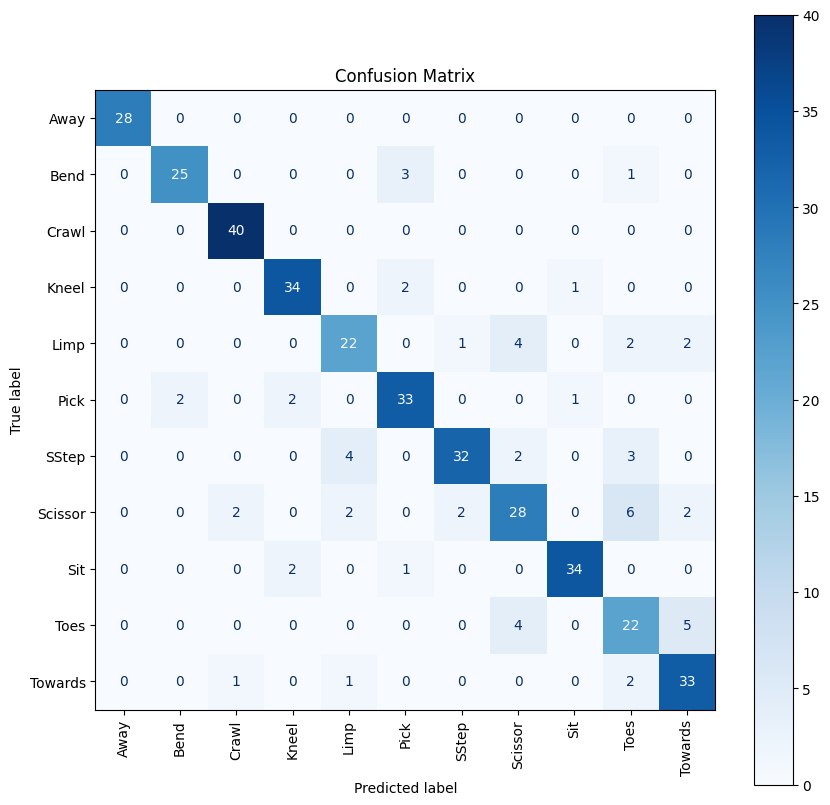

In [13]:
# --- 6. MODEL EVALUATION ---
print("\n                   --- MODEL EVALUATION ---")
best_model_path = os.path.join(MODEL_PATH,"MultiInputBestModel.pth")
if os.path.exists(best_model_path):
  print(f"loading best model from {best_model_path}")
  model.load_state_dict(torch.load(best_model_path))
else:
  print("no best model found at the specified path")

model.eval() # Set model to evaluation mode

all_preds = []
all_labels = []

# Get Predictions for the entire validation set
with torch.no_grad():
  for images, radar_labels, activity_names in validation_loader:
    images = images.to(device)
    radar_labels = radar_labels.to(device)
    activity_names = activity_names.to(device)

    preds = model(images, radar_labels)
    _, predicted = torch.max(preds.data, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(activity_names.cpu().numpy())

# 1.) Classification Report (Precision, Recall, F1-Score)
print("\n Classification Report : ")
print(classification_report(all_labels, all_preds, target_names = activity_label_names))

# 2.) Confusion Matrix
print("\n Confusion Matrix : ")
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = activity_label_names)

fig, ax = plt.subplots(figsize = (10, 10))
disp.plot(ax = ax, xticks_rotation='vertical', cmap = 'Blues')
plt.title("Confusion Matrix")
plt.show()
